<a href="https://colab.research.google.com/github/ph2017001/MachineLearning_Wkshp/blob/master/ImageClassifierUsingKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import numpy as np

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


When loading MNIST or Fashion MNIST using Keras rather than Scikit-Learn, one important difference is that every image is represented as a 28 × 28 array rather than a 1D array of size 784. Moreover, the pixel intensities are represented as integers (from 0 to 255) rather than floats (from 0.0 to 255.0). Let’s take a look at the shape and data type of the training set:

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_train_full.dtype

dtype('uint8')

The dataset is already split into a training set and a test set, but there is no validation set, so we’ll create one now. Additionally, since we are going to train the neural network using Gradient Descent, we must scale the input features. For simplicity, we’ll scale the pixel intensities down to the 0–1 range by dividing them by 255.0 (this also converts them to floats):

In [5]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5. Easy. For Fashion MNIST, however, we need the list of class names to know what we are dealing with:

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

For example, the first image in the training set represents a coat:

In [7]:
class_names[y_train[0]]

'Coat'

### CREATING THE MODEL USING THE SEQUENTIAL API
Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [8]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

- The first line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. This is called the Sequential API.

- Next, we build the first layer and add it to the model. It is a Flatten layer whose role is to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). This layer does not have any parameters; it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the input_shape, which doesn’t include the batch size, only the shape of the instances. Alternatively, you could add a keras.layers.InputLayer as the first layer, setting input_shape=[28,28].

- Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). 

- Then we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.

- Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model:

In [ ]:
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax")
# ])

In [ ]:
output_layer = keras.layers.Dense(10)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Note that Dense layers often have a lot of parameters. For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data. 

In [10]:
model.layers

In [11]:
hidden1 = model.layers[1]

In [12]:
hidden1.name

'dense'

In [ ]:
model.get_layer('dense') is hidden1

All the parameters of a layer can be accessed using its get_weights() and set_weights() methods

In [13]:
weights, biases = hidden1.get_weights()

In [14]:
weights

array([[ 0.05432279,  0.04857799,  0.02928623, ..., -0.04676798,
        -0.0690281 ,  0.04782846],
       [-0.07342072,  0.02058458, -0.03663935, ...,  0.0638855 ,
         0.05712844,  0.02800915],
       [ 0.00958646, -0.04876468,  0.03676938, ...,  0.01614436,
        -0.0530329 ,  0.07297415],
       ...,
       [-0.00726873,  0.03602778, -0.01339871, ..., -0.01547906,
        -0.03348595,  0.03879558],
       [-0.04206883,  0.03533188, -0.00983449, ..., -0.05082707,
         0.07076606,  0.02633436],
       [-0.00276214,  0.04057926,  0.07239085, ...,  0.0733076 ,
        -0.03279757, -0.06938972]], dtype=float32)

In [15]:
weights.shape

(784, 300)

In [16]:
biases.shape

(300,)

The shape of the weight matrix depends on the number of inputs. This is why it is recommended to specify the input_shape when creating the first layer in a Sequential model. However, if you do not specify the input shape, it’s OK: Keras will simply wait until it knows the input shape before it actually builds the model. 

### COMPILING THE MODEL
After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

We use the "sparse_categorical_crossentropy" loss because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. If we were doing binary classification (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.

### TRAINING AND EVALUATING THE MODEL
Now the model is ready to be trained. For this we simply need to call its fit() method:

In [18]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7132 - accuracy: 0.7653 - val_loss: 0.5072 - val_accuracy: 0.8274
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4898 - accuracy: 0.8290 - val_loss: 0.4548 - val_accuracy: 0.8422
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4436 - accuracy: 0.8454 - val_loss: 0.4140 - val_accuracy: 0.8582
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4190 - accuracy: 0.8535 - val_loss: 0.4007 - val_accuracy: 0.8640
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3972 - accuracy: 0.8609 - val_loss: 0.3891 - val_accuracy: 0.8674
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3816 - accuracy: 0.8658 - val_loss: 0.3942 - val_accuracy: 0.8608
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3675 - accuracy: 0.8699 - val_loss: 0.3959 - val_accuracy:

And that’s it! The neural network is trained.

The fit() method returns a History object containing the training parameters (history.params), the list of epochs it went through (history.epoch), and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set

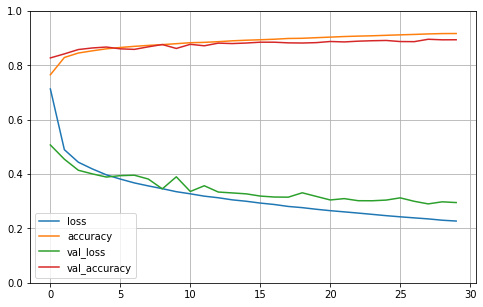

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

You can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. <br/>
You can tell that the model has not quite converged yet, as the validation loss is still going down, so you should probably continue training. It’s as simple as calling the fit() method again, since Keras just continues training where it left off .

In [20]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3288 - accuracy: 0.8861


[0.3287631571292877, 0.8860999941825867]

### USING THE MODEL TO MAKE PREDICTIONS
Next, we can use the model’s predict() method to make predictions on new instances. Since we don’t have actual new instances, we will just use the first three instances of the test set:

In [21]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

As you can see, for each instance the model estimates one probability per class, from class 0 to class 9. For example, for the first image it estimates that the probability of class 9 (ankle boot) is 96%, the probability of class 5 (sandal) is 3%, the probability of class 7 (sneaker) is 1%, and the probabilities of the other classes are negligible.<br/>
If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the predict_classes() method instead:

In [23]:
import numpy as np
y_pred = model.predict_classes(X_new)
print(y_pred)
print(np.array(class_names)[y_pred])

[9 2 1]
['Ankle boot' 'Pullover' 'Trouser']


Let us now see what these images were actually:

In [24]:
y_new = y_test[:3]
y_new


array([9, 2, 1], dtype=uint8)

In [25]:
print(np.array(class_names)[y_new])

['Ankle boot' 'Pullover' 'Trouser']
